In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
final_fig_path = "../../Manuscript/Figures/"
from time import time
from fun_response_funs import *
from fitness_funs import *
import pandas as pd
import random

56265381

We use the non-dimensionalized parameters

fitness_funs from fitness_funs.py are in terms of non-dimensionalized params

In [2]:
from fun_response_funs import *

def fun_response_non_dim(x, N1, N2, index, H1, H2, α2_fun_type,**params):
    '''
    non-dimensionalized functional response to prey as a function of predator group size (x) and 
    (non-dimensionalized prey population sizes (N1, N2)
    
    @inputs:
    x - pred group size
    N1, N2 - non-dim big prey and small prey pop sizes, respec
    index - 1 (big prey) or 2 (small prey)
    H1, H2 - non-dimensionalized handling times of big prey, small prey, respec
    params: a dictionary of other parameters, that at least must include 
                α1_of_1, α2_of_1, s1, s2

    @returns
    functional response for prey type <index> (a float)

    @examples
    >>fun_response_non_dim(x=1,N1=0.8,N2=0.8,index=1,a=1,H1=5,H2=5, 
                    **dict(α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2) )
    0.008000000000000002
    '''
    if α2_fun_type == 'constant':
        α2 = params['α2_of_1']
    elif α2_fun_type == 'sigmoid':
        α2 = fun_attack_rate(x,2,**params)

        
    α1 = fun_attack_rate(x,1,**params)
    if index == 1:
        numerator = α1*N1
    elif index == 2:
        numerator = α2*N2
    denominator = 1 + α1*H1*N1 + α2*H2*N2
    return numerator/denominator
    
def pop_model_one_grp_size(t, initialstate,x, params):
    P, N1, N2 = initialstate
    dPdT = dPdT_one_grp_size(P, N1, N2, x, **params)
    dN1dT = dN1dT_one_grp_size(P, N1, N2, x, **params)
    dN2dT = dN2dT_one_grp_size(P, N1, N2, x, **params)

    return [dPdT, dN1dT, dN2dT]
    
def dPdT_one_grp_size(P, N1, N2, x, η1, η2, β1, β2, **params):
    '''
    the equation for dPdT, the change in predator population size versus time, 
    non-dimensionalized. All preditors in groups of the same size

    @inputs
    P, N1, N2 - nondimensionalized predator, big prey, and small prey pop sizes
    x - the group size of predators
    params - dic of params: η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, s1, s2,
    '''
    F_of_x = P/x
    tildeY1_of_x = fun_response_non_dim(x,N1,N2,1,**params)
    tildeY2_of_x = fun_response_non_dim(x,N1,N2,1,**params)
    D = 1 - η1 - η2

    return F_of_x*(β1*tildeY1_of_x + β2 * tildeY2_of_x) - D*P
    
def dN1dT_one_grp_size(P, N1, N2, x, η1, A1, **params):
    tildeY1_of_x = fun_response_non_dim(x,N1,N2,1,**params)
    F_of_x = P/x
    return η1*N1*(1-N1) - A1 * F_of_x * tildeY1_of_x


def dN2dT_one_grp_size(P, N1, N2, x, η2, A1, **params):
    tildeY2_of_x = fun_response_non_dim(x,N1,N2,2,**params)
    F_of_x = P/x
    A2 = 1 - A1
    return η2*N2*(1-N2) - A2 * F_of_x * tildeY2_of_x   



In [93]:
η1 = 0.2; η2 = 0.2

#caption +=

In [96]:
s = print(caption)

The parameters are $\eta_1 = 0.2, \eta_2 = 0.2


In [48]:
def make_id_params(η1, η2, A1, β1, β2, H1, H2, s1, s2, α2_fun_type,**params):
    string = '%d%d%d%d%d%d%d%d%d'%(η1*10, η2*10, A1*10, β1, β2, H1, H2, s1, s2)
    string = string + '_alpha2' + α2_fun_type
    return string
def print_param_caption(η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, 
                        s1, s2, α2_fun_type,**params):
    caption = 'The parameters are '
    caption += f'$\\eta_1 = {η1}, \\eta_2 = {η2}, '
    caption += f'A_1 = {A1}, \\beta_1 = {β1}, \\beta_2 = {β2}, '
    caption += f'H_1 = {H1}, H2 = {H2}, ' 
    if α2_fun_type == 'constant':
        caption += f'\\alpha_1(1) = {α1_of_1}, s_1 ={s1}$, '
        caption += f'and $\\alpha_2(x) = {α2_of_1}$ is constant.'
    else:
        caption += f'\\alpha_1(1) = {α1_of_1}, \\alpha_2(1) = {α2_of_1}, '
        caption += f's_1 = {s1}$, and $s_2 = {s2}$' 
    
    print(caption)
def print_initial_states_caption(initialstates, colors):
    caption =""
    for initialstate, color in zip(initialstates, colors):
        P,N1,N2 = initialstate
        caption += f"$(P={P}, N_1 = {N1}, N_2 = {N2})$ ({color}), "
    caption = caption[:-2]
    caption += "."
    print(caption)
#    The initial states are 

In [30]:
params_reg = dict(η1 = 0.2, η2 = 0.7, A1 = 0.5, β1 = 7, β2 = 2, H1=0, H2=0, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant')
params_reg_id = params_reg

In [40]:
print_param_caption(**params_reg.copy())

The parameters are $\eta_1 = 0.2, \eta_2 = 0.7, A_1 = 0.5, \beta_1 = 7, \beta_2 = 2, H_1 = 0, H2 = 0, \alpha_1(1) = 0.05, s_1 =2$, and $\alpha_2(x) = 0.95$ is constant.


In [10]:
t=1; P=0.1; N1=1; N2=1; x=1
pop_model_one_grp_size(t, [P, N1, N2],x, params_reg.copy())

[0.035, -0.0025000000000000005, -0.0475]

In [49]:
initialstate1 = [0.2, 1, 1]
initialstate2 = [8,0.5,0.2]
initialstate3 = [12, 0.1, 0.3]
initialstates = [initialstate1, initialstate2, initialstate3]
colors = ['black', 'blue', 'red']
print_initial_states_caption(initialstates, colors)

$(P=0.2, N_1 = 1, N_2 = 1)$ (black), $(P=8, N_1 = 0.5, N_2 = 0.2)$ (blue), $(P=12, N_1 = 0.1, N_2 = 0.3)$ (red).


# Alpha 2 constant

6.222222222222223
6.222222222222223
6.222222222222219
275720022_alpha2constant
popdyn_all1_275720022_alpha2constant.png
1.2188365650969504
1.2188365650969504
1.2188365650969508
275720022_alpha2constant
popdyn_all3_275720022_alpha2constant.png
3.5555555557387377
3.55555555573874
3.555555555738739
275720022_alpha2constant
popdyn_all10_275720022_alpha2constant.png
6.22222222222222
6.2222222222222205
6.222222222222221
275720022_alpha2constant
popdyn_all20_275720022_alpha2constant.png


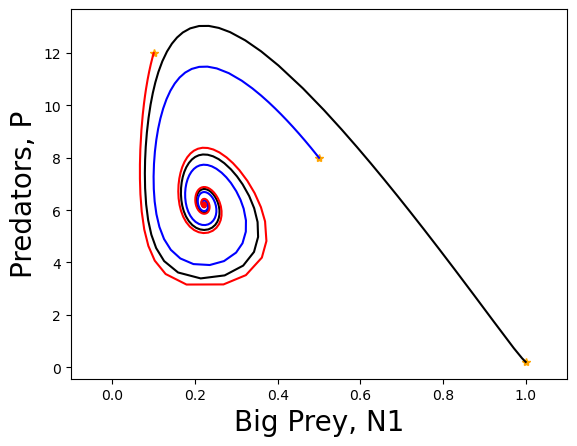

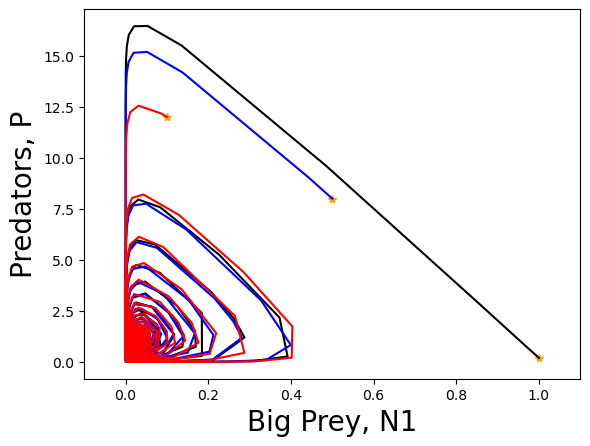

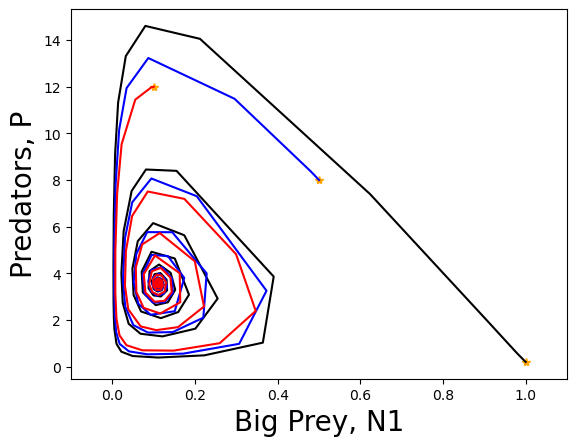

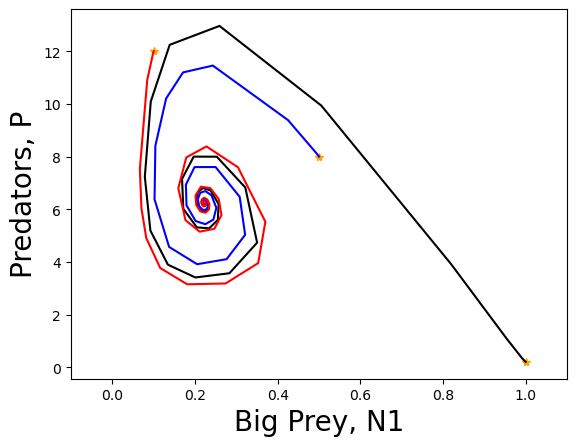

In [53]:
for x in [1, 3, 10, 20]:
    t_f = 10000
    fig = plt.figure()
    for i,initialstate in enumerate(initialstates):
        out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                    args=(x, params_reg.copy()))
        plt.plot(initialstate[1], initialstate[0], marker = '*', c = 'orange')
        plt.plot(out.y[1,:],out.y[0,:],colors[i])
        print(out.y[0,-1])
    
    
    
    plt.xlim([-0.1,1.1])
    plt.xlabel('Big Prey, N1', fontsize = 20)
    plt.ylabel('Predators, P', fontsize = 20)
    params_id = make_id_params(**params_reg.copy())
    print(params_id)
    figname = 'popdyn_all' + str(x) +'_'+params_id + '.png'
    print(figname)
    fig.savefig(final_fig_path + \
                    figname
                      , bbox_inches = 'tight')

1.2188365650969504
1.2188365650969504
1.2188365650969508
275720022_alpha2constant
popdyn_all3_275720022_alpha2constant.png


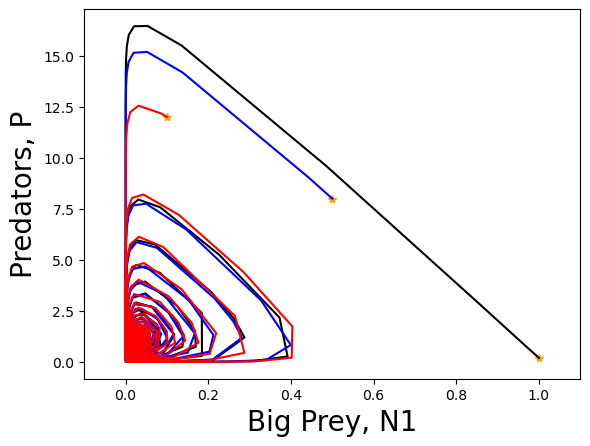

In [67]:
t_f = 10000
x=3
for i,initialstate in enumerate(initialstates):
    out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
    plt.plot(initialstate[1], initialstate[0], marker = '*', c = 'orange')
    plt.plot(out.y[1,:],out.y[0,:],colors[i])
    print(out.y[0,-1])



plt.xlim([-0.1,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)
params_id = make_id_params(**params_reg.copy())
print(params_id)
figname = 'popdyn_all' + str(x) +'_'+params_id + '.png'
print(figname)
plt.gcf().savefig(final_fig_path + \
                figname
                  , bbox_inches = 'tight')

3.5555555557387377
3.55555555573874
3.555555555738739
275720022_alpha2constant
popdyn_all10_275720022_alpha2constant.png


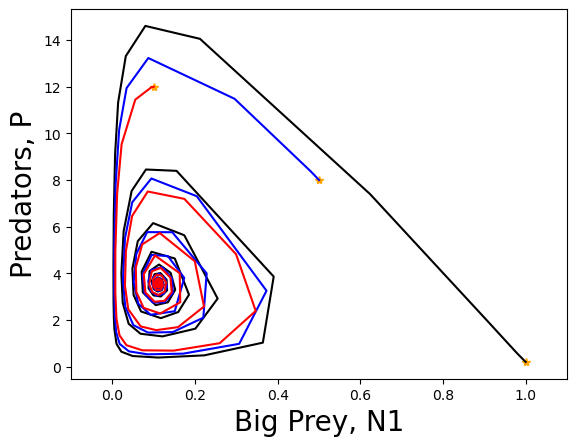

In [68]:
t_f = 10000
x=10
for i,initialstate in enumerate(initialstates):
    out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
    plt.plot(initialstate[1], initialstate[0], marker = '*', c = 'orange')
    plt.plot(out.y[1,:],out.y[0,:],colors[i])
    print(out.y[0,-1])



plt.xlim([-0.1,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)
params_id = make_id_params(**params_reg.copy())
print(params_id)
figname = 'popdyn_all' + str(x) +'_'+params_id + '.png'
print(figname)
plt.gcf().savefig(final_fig_path + \
                figname
                  , bbox_inches = 'tight')

6.22222222222222
6.2222222222222205
6.222222222222221
275720022_alpha2constant
popdyn_all20_275720022_alpha2constant.png


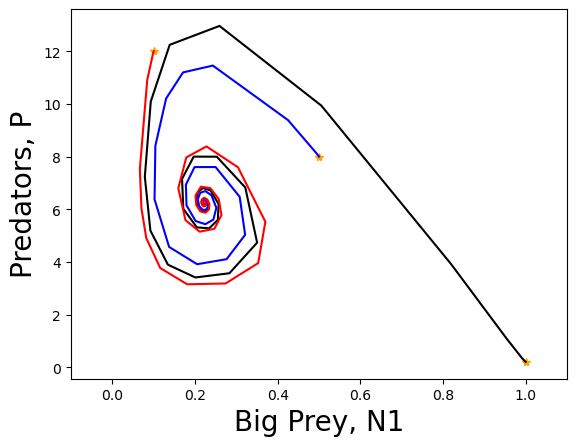

In [69]:
t_f = 10000
x=20
for i,initialstate in enumerate(initialstates):
    out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
    plt.plot(initialstate[1], initialstate[0], marker = '*', c = 'orange')
    plt.plot(out.y[1,:],out.y[0,:],colors[i])
    print(out.y[0,-1])



plt.xlim([-0.1,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)
params_id = make_id_params(**params_reg.copy())
print(params_id)
figname = 'popdyn_all' + str(x) +'_'+params_id + '.png'
print(figname)
plt.gcf().savefig(final_fig_path + \
                figname
                  , bbox_inches = 'tight')

Text(0, 0.5, 'Predators, P')

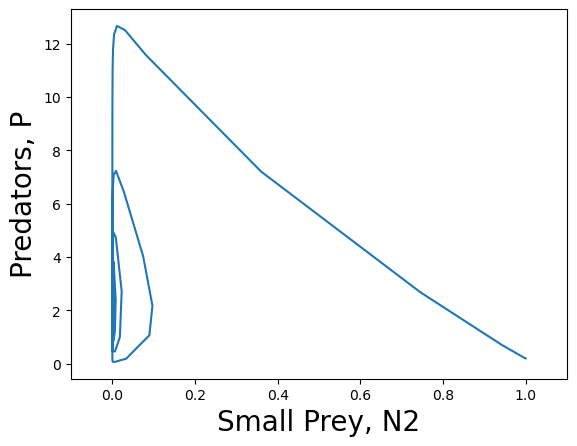

In [54]:
plt.plot(out.y[2,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Small Prey, N2', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

Text(0, 0.5, 'Predators, P')

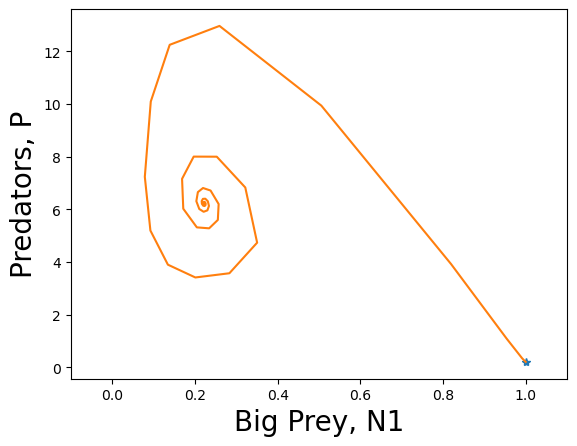

In [65]:
t_f = 1000
initialstate = [0.2, 1, 1]
x=20
out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=(x, params_reg.copy()))
plt.plot(initialstate[1], initialstate[0], marker = '*')
plt.plot(out.y[1,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Big Prey, N1', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

Text(0, 0.5, 'Predators, P')

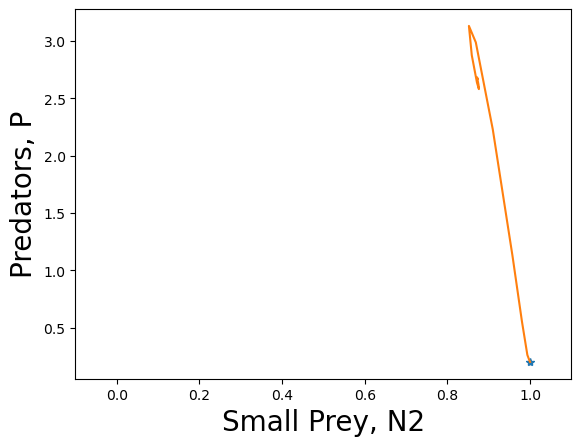

In [61]:
plt.plot(initialstate[1], initialstate[0], marker = '*')
plt.plot(out.y[2,:],out.y[0,:])
plt.xlim([-0.1,1.1])
plt.xlabel('Small Prey, N2', fontsize = 20)
plt.ylabel('Predators, P', fontsize = 20)

In [4]:
1*0.05*0.8

0.04000000000000001

In [5]:
1+5*0.05*0.8 + 5*0.95*0.8

5.0

In [6]:
0.04/5

0.008